In [277]:
import torch 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [146]:
#Firs let's import the input data
folder = "Three_node_fy"
nb_periods=365
t_per_period = 24

loads_t = dict()
generators_t = dict()
results = dict()

loads_t["raw"] = pd.read_csv(f"../00.Data_generation/InputData/Three_node_fy/loads-p_set.csv")
generators = pd.read_csv(f"../00.Data_generation/InputData/Three_node_fy/generators.csv")
generators_t["raw"] = pd.read_csv(f"../00.Data_generation/InputData/Three_node_fy/generators-p_max_pu.csv")
lines = pd.read_csv(f"../00.Data_generation/InputData/Three_node_fy/lines.csv")

#And the results
results["raw"] = pd.read_csv(f"../00.Data_generation/Results/{folder}/{nb_periods}_{t_per_period}.csv")


In [344]:
#
fractions = {"train":0.2,"test":0.8}
train_size = int(len(loads_t["raw"]) * fractions["train"])


# loads_t["test_raw"] = loads_t["raw"].iloc[:,train_size:]
# generators_t["test_raw"] = generators_t["raw"].iloc[:,train_size:]

input_data_arr = dict()
input_data_torch = dict()
results_torch = dict()
#Then, we chop the temporal data into portions specified by the period dimensions and split the set into training and testing data
for n in ["train", "test"]:
    #First split into train and test data
    if n == "train": 
        loads_t[f"{n}_raw"] = loads_t["raw"].iloc[:train_size,:]
        generators_t[f"{n}_raw"] = generators_t["raw"].iloc[:train_size,:]
        results[f"{n}_raw"] = results["raw"].iloc[:int(train_size/t_per_period),:]["obj"].to_numpy()
    else:
        loads_t[f"{n}_raw"] = loads_t["raw"].iloc[train_size:,:]
        generators_t[f"{n}_raw"] = generators_t["raw"].iloc[train_size:,:]
        results[f"{n}_raw"] = results["raw"].iloc[int(train_size/t_per_period):,:]["obj"].to_numpy()
        
#     #Then, chop into portions dependent on period length --> This way of chopping will be usefull later
#     loads_t[f"{n}_chopped"] = np.stack([loads_t[f"{n}_raw"].iloc[i*(t_per_period):(i+1)*(t_per_period),1:].to_numpy() for i in range(int(nb_periods*fractions[n]))])
#     generators_t[f"{n}_chopped"] =np.stack([generators_t[f"{n}_raw"].iloc[i*(t_per_period):(i+1)*(t_per_period),1:].to_numpy() for i in range(int(nb_periods*fractions[n]))])
    
#     #Finally, we convert the chopped data into 1-dimensional pytorch tensors. We start 1-dimensional here because that is easiest
#     #loads_t[f"{n}_chopped_tens"] = loads_t[f"{n}_chopped"].reshape(-1,int(nb_periods*fractions[n]))
#     #generators_t[f"{n}_chopped_tens"] = generators_t[f"{n}_chopped"].reshape(-1,int(nb_periods*fractions[n]))
    
    #Generate a numpy array of input samples that has the periods as one dimension.
    input_data_arr[n] = np.stack([
        np.concatenate((loads_t[f"{n}_raw"].iloc[i*(t_per_period):(i+1)*(t_per_period),1:].to_numpy().flatten(),
                        generators_t[f"{n}_raw"].iloc[i*(t_per_period):(i+1)*(t_per_period),1:].to_numpy().flatten()),
                       axis=0) 
        for i in range(int(nb_periods*fractions[n])) ])
    
    #And transform to pytorch tensors 
    input_data_torch[n] = torch.from_numpy(input_data_arr[n])
    results_torch[n] = torch.from_numpy(results[f"{n}_raw"])

In [345]:
# Define the neural network model
class ObjectiveEstimator_h(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.hidden_layer1 = torch.nn.Linear(input_size, hidden_size)
        # self.hidden_layer2 = torch.nn.Linear(hidden_size, hidden_size)
        self.output_layer = torch.nn.Linear(hidden_size, output_size)

        # define the device to use (GPU or CPU)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    def forward(self, input):
        hidden = torch.relu(self.hidden_layer1(input))
        # hidden = torch.relu(self.hidden_layer2(hidden))
        output = self.output_layer(hidden)
        return output
# Define the neural network model
class ObjectiveEstimator(torch.nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.output_layer = torch.nn.Linear(input_size, output_size)

        # define the device to use (GPU or CPU)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    def forward(self, input):
        output = self.output_layer(input)
        return output

In [346]:
model = ObjectiveEstimator(input_size=96, output_size=1)
model_h = ObjectiveEstimator_h(input_size=96,hidden_size = 200, output_size=1)
optimizer = torch.optim.Adam(model.parameters(), lr=1e4)
optimizer_h = torch.optim.Adam(model_h.parameters(), lr=1e1)

In [347]:
# Train the model
for epoch in range(100):
    # Forward pass
    train_predictions = model(input_data_torch["train"].float())
    train_loss = torch.nn.MSELoss()(train_predictions.float().squeeze(), results_torch["train"].float())
    
    train_predictions_h = model_h(input_data_torch["train"].float())
    train_loss_h = torch.nn.MSELoss()(train_predictions_h.float().squeeze(), results_torch["train"].float())
    

    # Backward pass
    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()\
    
    optimizer_h.zero_grad()
    train_loss_h.backward()
    optimizer_h.step()

    # Print the training loss every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f'Epoch {epoch + 1}, Train Loss: {train_loss.item()},{train_loss_h.item()}')

Epoch 10, Train Loss: 1.1956577623598957e+20,2.4519095225655964e+20
Epoch 20, Train Loss: 8.072366431259329e+18,5.606280927267049e+19
Epoch 30, Train Loss: 2.549966256514846e+19,1.2699000860022145e+19
Epoch 40, Train Loss: 3.185573477615875e+19,1.0220508136968552e+19
Epoch 50, Train Loss: 1.5461863573902328e+19,1.4249752059837415e+19
Epoch 60, Train Loss: 7.985120183595303e+18,8.024460159881314e+18
Epoch 70, Train Loss: 9.214504475576762e+18,8.700002852765958e+18
Epoch 80, Train Loss: 7.946762071192895e+18,7.862353113284346e+18
Epoch 90, Train Loss: 8.02525840532308e+18,7.746727920751608e+18
Epoch 100, Train Loss: 7.825662410265461e+18,7.700690819140813e+18


In [348]:
# Evaluate the model on the test set
test_predictions = model(input_data_torch["test"].float())
test_predictions_h = model_h(input_data_torch["test"].float())

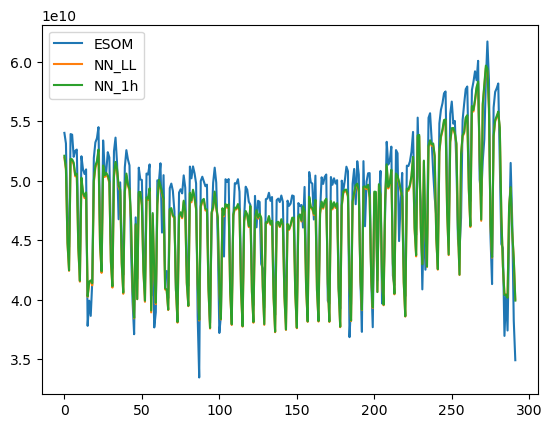

In [349]:
#plt.plot(test_predictions.)
ax = plt.plot(results["test_raw"],label = "ESOM")
plt.plot(test_predictions.detach().numpy(),label = "NN_LL")
plt.plot(test_predictions_h.detach().numpy(),label = "NN_1h")
plt.legend()



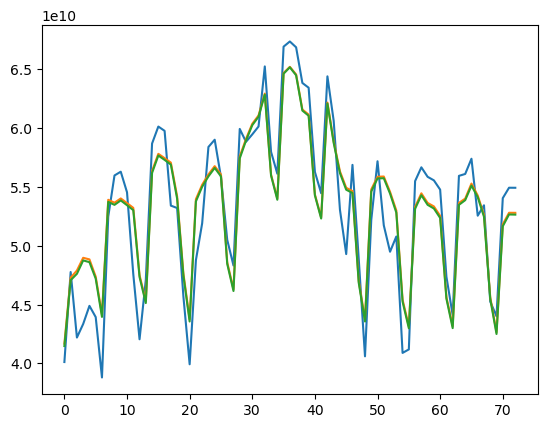

In [351]:
#plt.plot(test_predictions.)
ax = plt.plot(results["train_raw"], label = "ESOM")
plt.plot(train_predictions.detach().numpy(),label = "NN_LL")
plt.plot(train_predictions_h.detach().numpy(),label = "NN_LL")

